# GC Numba GPU

Verifica se a GPU está configurada e ativa no GC:

In [1]:
from numba import cuda
print(cuda.gpus)

<Managed Device 0>


In [2]:
! nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-6bf4df99-a9a9-4944-bf53-cd33daea33bf)


In [3]:
! nvidia-smi

Sat Sep 25 15:10:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    35W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import numpy as np, math
from time import time
from numba import cuda

# parameters
n            = 2400    # nxn grid
energy       = 1       # energy to be injected per iteration
niters       = 250     # number of iterations
# initialize the data arrays
anew         = np.zeros((n + 2, n + 2), np.float64)
aold         = np.zeros((n + 2, n + 2), np.float64)
# initialize three heat sources
sources      = np.empty((3, 2), np.int16)
sources[:,:] = [ [n//2, n//2], [n//3, n//3], [n*4//5, n*8//9] ]

# configure blocks & grids
## set the number of threads in a block
threads_per_block = (8, 8)
## calculate the number of thread blocks in the grid
blocks_per_grid_x = math.ceil(aold.shape[0] / threads_per_block[0])
blocks_per_grid_y = math.ceil(aold.shape[1] / threads_per_block[1])
blocks_per_grid   = (blocks_per_grid_x, blocks_per_grid_y)

# computationally intensive core
@cuda.jit
def kernel(a1, a2) :
    n = a1.shape[0] - 1
    i, j = cuda.grid(2)
    if (i > 0 and j > 0) and (i < n and j < n) :
        a1[i,j] = (a2[i,j]/2.0
                   +(a2[i-1,j]+a2[i+1,j]+a2[i,j-1]+a2[i,j+1])/8.0)

# insert heat
@cuda.jit
def insert_heat(a, sources, energy) :
    n = a.shape[0] - 1
    i, j = cuda.grid(2)
    if ( (sources[0, 0] == i and sources[0, 1] == j) or
         (sources[1, 0] == i and sources[1, 1] == j) or
         (sources[2, 0] == i and sources[2, 1] == j) ) :
        a[i, j] += energy

# main routine
t0 = -time()    # time measure
t1 = 0
t2 = 0

t_ = time()
# copy the arrays to the device
anew_global_mem    = cuda.to_device(anew)
aold_global_mem    = cuda.to_device(aold)
sources_global_mem = cuda.to_device(sources)
t2 += time() - t_

for _ in range(0, niters, 2) :
    t_ = time()
    kernel[blocks_per_grid, threads_per_block](
        anew_global_mem, aold_global_mem)
    insert_heat[blocks_per_grid, threads_per_block](
        anew_global_mem, sources_global_mem, energy)    
    kernel[blocks_per_grid, threads_per_block](
        aold_global_mem, anew_global_mem)
    insert_heat[blocks_per_grid, threads_per_block](
        aold_global_mem, sources_global_mem, energy)
    t1 += time() - t_

t_ = time()
# copy the result back to the host
aold = aold_global_mem.copy_to_host()
t2 += time() - t_

# system total heat
heat = np.sum(aold[1:-1, 1:-1])

t0 += time()

# show the result
print(f"Heat: {heat:.4f}", end=" | ")
print(f"Time: {t0:.4f}", end=" | ")
print(f"Kernel: {t1:.4f}", end=" | ")
print(f"Memory: {t2:.4f}")

Heat: 750.0000 | Time: 1.8965 | Kernel: 0.9941 | Memory: 0.8939


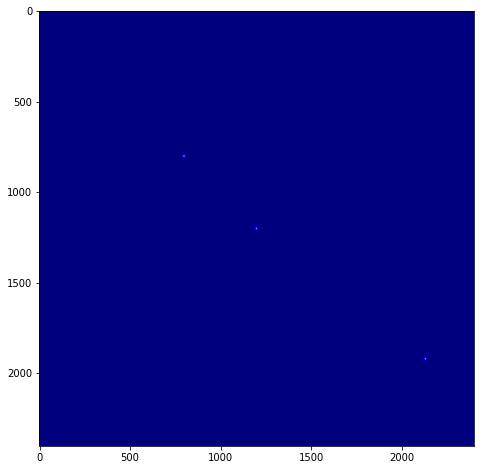

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(aold, cmap='jet')

---

# Grade 8 x 8 para visualizar o resultado final

In [6]:
import numpy as np, math
from time import time
from numba import cuda

# parameters
n            = 8    # nxn grid
energy       = 1       # energy to be injected per iteration
niters       = 250     # number of iterations
# initialize the data arrays
anew         = np.zeros((n + 2, n + 2), np.float64)
aold         = np.zeros((n + 2, n + 2), np.float64)
# initialize three heat sources
sources      = np.empty((3, 2), np.int16)
sources[:,:] = [ [n//2, n//2], [n//3, n//3], [n*4//5, n*8//9] ]

# configure blocks & grids
## set the number of threads in a block
threads_per_block = (8, 8)
## calculate the number of thread blocks in the grid
blocks_per_grid_x = math.ceil(aold.shape[0] / threads_per_block[0])
blocks_per_grid_y = math.ceil(aold.shape[1] / threads_per_block[1])
blocks_per_grid   = (blocks_per_grid_x, blocks_per_grid_y)

# computationally intensive core
@cuda.jit
def kernel(a1, a2) :
    n = a1.shape[0] - 1
    i, j = cuda.grid(2)
    if (i > 0 and j > 0) and (i < n and j < n) :
        a1[i,j] = (a2[i,j]/2.0
                   +(a2[i-1,j]+a2[i+1,j]+a2[i,j-1]+a2[i,j+1])/8.0)

# insert heat
@cuda.jit
def insert_heat(a, sources, energy) :
    n = a.shape[0] - 1
    i, j = cuda.grid(2)
    if ( (sources[0, 0] == i and sources[0, 1] == j) or
         (sources[1, 0] == i and sources[1, 1] == j) or
         (sources[2, 0] == i and sources[2, 1] == j) ) :
        a[i, j] += energy

# main routine
t0 = -time()    # time measure
t1 = 0
t2 = 0

t_ = time()
# copy the arrays to the device
anew_global_mem    = cuda.to_device(anew)
aold_global_mem    = cuda.to_device(aold)
sources_global_mem = cuda.to_device(sources)
t2 += time() - t_

for _ in range(0, niters, 2) :
    t_ = time()
    kernel[blocks_per_grid, threads_per_block](
        anew_global_mem, aold_global_mem)
    insert_heat[blocks_per_grid, threads_per_block](
        anew_global_mem, sources_global_mem, energy)    
    kernel[blocks_per_grid, threads_per_block](
        aold_global_mem, anew_global_mem)
    insert_heat[blocks_per_grid, threads_per_block](
        aold_global_mem, sources_global_mem, energy)
    t1 += time() - t_

t_ = time()
# copy the result back to the host
aold = aold_global_mem.copy_to_host()
t2 += time() - t_

# system total heat
heat = np.sum(aold[1:-1, 1:-1])

t0 += time()

# show the result
print(f"Heat: {heat:.4f}", end=" | ")
print(f"Time: {t0:.4f}", end=" | ")
print(f"Kernel: {t1:.4f}", end=" | ")
print(f"Memory: {t2:.4f}")

Heat: 102.6641 | Time: 0.5495 | Kernel: 0.5432 | Memory: 0.0058


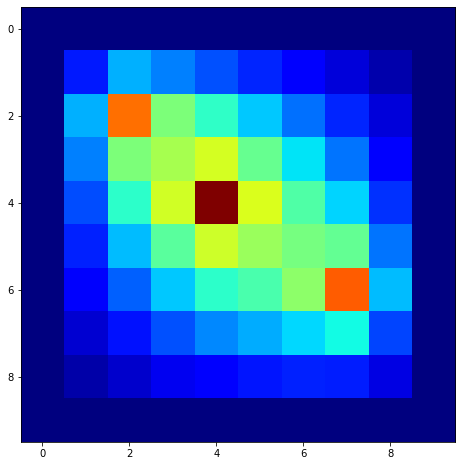

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(aold, cmap='jet')

---

# Grade 24 x 24 para visualizar o resultado final

In [8]:
import numpy as np, math
from time import time
from numba import cuda

# parameters
n            = 24     # nxn grid
energy       = 1       # energy to be injected per iteration
niters       = 250     # number of iterations
# initialize the data arrays
anew         = np.zeros((n + 2, n + 2), np.float64)
aold         = np.zeros((n + 2, n + 2), np.float64)
# initialize three heat sources
sources      = np.empty((3, 2), np.int16)
sources[:,:] = [ [n//2, n//2], [n//3, n//3], [n*4//5, n*8//9] ]

# configure blocks & grids
## set the number of threads in a block
threads_per_block = (8, 8)
## calculate the number of thread blocks in the grid
blocks_per_grid_x = math.ceil(aold.shape[0] / threads_per_block[0])
blocks_per_grid_y = math.ceil(aold.shape[1] / threads_per_block[1])
blocks_per_grid   = (blocks_per_grid_x, blocks_per_grid_y)

# computationally intensive core
@cuda.jit
def kernel(a1, a2) :
    n = a1.shape[0] - 1
    i, j = cuda.grid(2)
    if (i > 0 and j > 0) and (i < n and j < n) :
        a1[i,j] = (a2[i,j]/2.0
                   +(a2[i-1,j]+a2[i+1,j]+a2[i,j-1]+a2[i,j+1])/8.0)

# insert heat
@cuda.jit
def insert_heat(a, sources, energy) :
    n = a.shape[0] - 1
    i, j = cuda.grid(2)
    if ( (sources[0, 0] == i and sources[0, 1] == j) or
         (sources[1, 0] == i and sources[1, 1] == j) or
         (sources[2, 0] == i and sources[2, 1] == j) ) :
        a[i, j] += energy

# main routine
t0 = -time()    # time measure
t1 = 0
t2 = 0

t_ = time()
# copy the arrays to the device
anew_global_mem    = cuda.to_device(anew)
aold_global_mem    = cuda.to_device(aold)
sources_global_mem = cuda.to_device(sources)
t2 += time() - t_

for _ in range(0, niters, 2) :
    t_ = time()
    kernel[blocks_per_grid, threads_per_block](
        anew_global_mem, aold_global_mem)
    insert_heat[blocks_per_grid, threads_per_block](
        anew_global_mem, sources_global_mem, energy)    
    kernel[blocks_per_grid, threads_per_block](
        aold_global_mem, anew_global_mem)
    insert_heat[blocks_per_grid, threads_per_block](
        aold_global_mem, sources_global_mem, energy)
    t1 += time() - t_

t_ = time()
# copy the result back to the host
aold = aold_global_mem.copy_to_host()
t2 += time() - t_

# system total heat
heat = np.sum(aold[1:-1, 1:-1])

t0 += time()

# show the result
print(f"Heat: {heat:.4f}", end=" | ")
print(f"Time: {t0:.4f}", end=" | ")
print(f"Kernel: {t1:.4f}", end=" | ")
print(f"Memory: {t2:.4f}")

Heat: 512.0860 | Time: 0.6639 | Kernel: 0.6614 | Memory: 0.0019


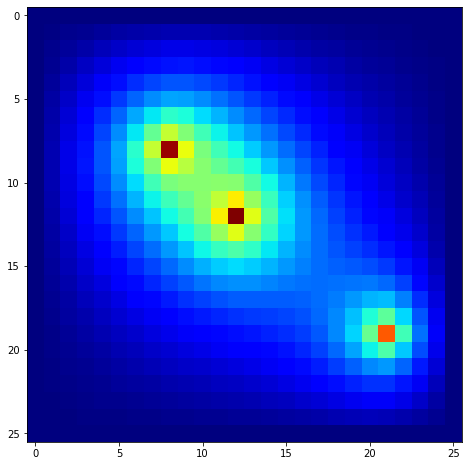

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(aold, cmap='jet')